In [34]:
import numpy as np
from neurodsp.sim import sim_combined
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.utils.data import create_times
from neurodsp.plts import plot_time_series, plot_power_spectra
from neurodsp.utils.norm import normalize_sig
# Import IRASA
from neurodsp.aperiodic import compute_irasa, fit_irasa
from scipy.linalg import norm
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from time import time
import fractions
from scipy import signal
from scipy.optimize import curve_fit

# Set random seed
np.random.seed(0)

# IRASA

IRASA stands for irregularly resampled auto-spectral analysis. It assumes the signal model is an aperiodic component, namely a 1/f component, added with finitely many sinusoids. These sinusoids manifest themselves as discrete spikes in the power spectrum. IRASA computes the aperiodic component appealing by appealing to the self-similar nature of signals whose power spectrum obeys a power law. Unlike FOOOF, IRASA requires access to the TIMES series in the time domain. By resampling the time series at non-integer rates, the spikes in the power spectrum corresponding to the sinusoids will be shifted in frequency by a quantity proportional to the resampling rate. However, self-similarity of the aperiodic component ensures that the power law decay remains the same across resamplings. Sinusoids are then averaged out across the power spectra of the resampled time series.

IRASA does not explicitly consider signals with a knee, nor does it consider signals where there are central frequencies with some variance around them as in the setting of FOOOF. Below are some examples which detail the performance on IRASA in various settings.

#### Notes
- IRASA seems to perform well when there are a few sinusoids added to the aperiodic component where the frequencies of those sinusoids are sufficiently different, e.g. well-spaced in the frequency range.
    - When the frequencies are close to one another, IRASA does not perform as well.
- Lower frequency sinusoids also seem to negatively impact IRASA's estimation.
- IRASA's behavior seems to be stable across different values of $\chi \in (-3, 0)$.

In [28]:
def log_space_freqs(freqs, n_points):
    """Given an array of frequency values, returns a subset of those frequency values which are approximately
    equispaced logarithmically."""
    
    # Grab the lowest and highest frequencies to form a logarithmic grid of frequencies, not necessarily
    # corresponding to frequencies in the array freqs
    f_start, f_end = freqs[0], freqs[-1]
    log_grid = np.logspace(np.log10(f_start), np.log10(f_end), n_points)
    
    # For every element in log_grid, find the closest element in freqs
    log_freq_indices = np.array([np.argmin(np.abs(log_freq - freqs)) for log_freq in log_grid]).astype('int')
    log_freqs = freqs[log_freq_indices]
    
    # Throw out any duplicates
    log_freqs = np.unique(log_freqs)
    
    return log_freqs

def fit_func(freqs, intercept, slope):
    """A fit function to use for fitting IRASA separated 1/f power spectra components."""

    return slope * freqs + intercept

def fit_irasa_logspace(freqs, psd_aperiodic):
    """Fit the IRASA derived aperiodic component of the spectrum. The fitting uses logarithmically
    spaced frequencies. This is basically copied from NeuroDSP's implementation with only a minor modification before
    the spectral fitting.

    Parameters
    ----------
    freqs : 1d array
        Frequency vector, in linear space.
    psd_aperidic : 1d array
        Power values, in linear space.

    Returns
    -------
    intercept : float
        Fit intercept value.
    slope : float
        Fit slope value.

    Notes
    -----
    This fits a linear function of the form `y = ax + b` to the log-log aperiodic power spectrum.
    """
    
    # Grab log spaced frequencies. Subsample by a factor of 2.
    resampled_freqs = log_space_freqs(freqs, freqs.shape[0]//2)
    
    # Grab the corresponding indices to resample the psd.
    resampled_idxs = np.array([np.argmin(np.abs(resampled_freq - freqs)) for resampled_freq in resampled_freqs])
    resampled_psd = psd_aperiodic[resampled_idxs]
    
    popt, _ = curve_fit(fit_func, np.log10(resampled_freqs), np.log10(resampled_psd))
    intercept, slope = popt

    return intercept, slope

def multiple_sines(n_seconds, fs, chi, sine_freqs, f_range=None, log_space_irasa=False):
    """
    Generates a time series with power law exponent chi and sinusoids with frequencies sine_freqs
    and returns the estimated power law exponent using IRASA.
    """
    
    times = create_times(n_seconds, fs)
    
    # Collect IRASA settings
    irasa_params = {'fs' : fs, 'f_range' : f_range}
    sim_components = {'sim_powerlaw': {'exponent' : chi},
                  'sim_oscillation': [{'freq' : sine_freq} for sine_freq in sine_freqs]}
    sig = sim_combined(n_seconds, fs, sim_components)
    

    freqs_irasa, psd_ap, psd_pe = compute_irasa(sig, **irasa_params)
    fit_off, fit_exp = fit_irasa(freqs_irasa, psd_ap) if not log_space_irasa else fit_irasa_logspace(freqs, psd_ap)
    
    return fit_exp

def sim_central_freq(n_seconds, fs, chi, central_freq, bw, ht):
    """
    Returns a time series whose full power spectrum consists of a power law with exponent chi
    and a gaussian peak at central_freq with standard deviation bw and relative height ht.
    

    Parameters
    -----------
    n_seconds: float
        Number of seconds elapsed in the time series.
    fs: float
        Sampling rate.
    chi: float
        Power law exponent.
    central_freq: float
        Central frequency for the gaussian peak in Hz.
    bw: float
        Bandwidth, or standard deviation, of gaussian peak in Hz.
    ht: float
        Relative height in log_10(Hz) over the aperiodic component of the gaussian peak at central_freq.

    Returns
    -------
    sig: 1d array
        Time series with desired power spectrum.

    Examples
    --------
    Simulate aperiodic noise with exponent -2 superimposed over an oscillatory component with
    central frequency 20.

    >>> sig = sim_gauss_peak(n_seconds=50, fs=500, chi=-2, central_freq=20, bw=5, ht=7)
    """

    times = create_times(n_seconds, fs)

    # Construct the aperiodic component and compute its Fourier transform. Only use the
    # first half of the frequencies from the Fourier transform since the signal is real.
    sig_components = {'sim_powerlaw': {'exponent': chi}}
    sig_ap = sim_combined(n_seconds, fs, sig_components)
    sig_len = sig_ap.shape[0]

    sig_ap_hat = np.fft.fft(sig_ap)[0:(sig_len//2+1)]

    # Create the range of frequencies that appear in the power spectrum since these
    # will be the frequencies in the cosines we sum below
    freqs = np.linspace(0, fs/2, num=sig_len//2 + 1, endpoint=True)

    # Construct the array of relative heights above the aperiodic power spectrum
    rel_heights = np.array([ ht * np.exp(-(f - central_freq)**2/(2*bw**2)) for f in freqs])

    # Build an array of the sum of squares of the cosines as they appear in the calculation of the
    # amplitudes
    cosine_norms = np.array([
                          norm(
                            np.cos(2*np.pi*f*times), 2
                          )**2 for f in freqs
                        ])

    # Build an array of the amplitude coefficients
    cosine_coeffs = np.array([
                    (-np.real(sig_ap_hat[ell]) + np.sqrt(np.real(sig_ap_hat[ell])**2 + (10**rel_heights[ell] - 1)*np.abs(sig_ap_hat[ell])**2))/cosine_norms[ell]
                    for ell in range(cosine_norms.shape[0])]
                )

    # Add cosines with the respective coefficients and with a random phase shift for each one
    sig_periodic = np.sum(
                    np.array(
                        [cosine_coeffs[ell]*np.cos(2*np.pi*freqs[ell]*times + 2*np.pi*np.random.rand()) for ell in range(cosine_norms.shape[0])]
                    ),
                    axis=0
                    )

    sig = sig_ap + sig_periodic

    return normalize_sig(sig)

def central_frequency(n_seconds, fs, chi, central_freq, bw, ht, f_range=None, log_space_irasa=False):
    """
    Generates a time series with power law exponent chi and sinusoids with frequencies sine_freqs
    and returns the estimated power law exponent using IRASA.
    """
    
    times = create_times(n_seconds, fs)
    
    # Collect IRASA settings
    irasa_params = {'fs' : fs, 'f_range' : f_range}
    sig = sim_central_freq(n_seconds, fs, chi, central_freq, bw, ht)
    

    freqs_irasa, psd_ap, psd_pe = compute_irasa(sig, **irasa_params)
    fit_off, fit_exp = fit_irasa(freqs_irasa, psd_ap) if not log_space_irasa else fit_irasa_logspace(freqs, psd_ap)
    
    return fit_exp

## No Oscillations

To start, we compare how well IRASA does at estimating the power law exponent when there are no oscillations. We compare this to the modified IRASA where we downsample the power spectrum at logarithmically spaced frequencies and look at how the error behaves as a function of the sampling rate. We choose the minimal sampling rate to be at least 3 TIMES that of the maximal frequency in the frequency range, since IRASA seems to perform very poorly when the maximum of the frequency range is close to the Nyquist frequency.

In [6]:
# Parameter ranges
N_SECONDS = 10
FS_RANGE = np.arange(150, 1000, 50, dtype='int')
CHIS = -1*np.arange(0, 3, 0.25)
F_RANGE = (1, 50)
NUM_TRIALS = 10

# Static constants
FS = 10**3
TIMES = create_times(N_SECONDS, FS)

# Take log spacing of frequencies. Round any floats to ints and throw out duplicates.
FREQS = log_space_freqs(np.arange(1, F_RANGE[1], dtype='int'), 25)

In [3]:
df = pd.DataFrame(index=FS_RANGE, columns=CHIS, data=np.zeros((FS_RANGE.shape[0], CHIS.shape[0])))
df_log = pd.DataFrame(index=FS_RANGE, columns=CHIS, data=np.zeros((FS_RANGE.shape[0], CHIS.shape[0])))

tic = time()
for fs, chi, trial_idx in product(FS_RANGE, CHIS, range(NUM_TRIALS)):
    irasa_params = {'fs' : fs, 'f_range' : F_RANGE}
    sim_components = {'sim_powerlaw': {'exponent' : chi}}
    sig = sim_combined(N_SECONDS, fs, sim_components)

    # Compute aperiodic component using IRASA
    freqs_irasa, psd_ap, psd_pe = compute_irasa(sig, **irasa_params)

    # Fit using all frequency data and using subsampled log-spaced frequencies
    fit_off, fit_exp = fit_irasa(freqs_irasa, psd_ap)
    fit_off_log, fit_exp_log = fit_irasa_logspace(freqs_irasa, psd_ap)
    
    df.loc[fs][chi] += np.abs(chi - fit_exp)
    df_log.loc[fs][chi] += np.abs(chi - fit_exp_log)

toc = time()
print(f"{toc-tic:.2f} seconds")
df /= NUM_TRIALS

152.61 seconds


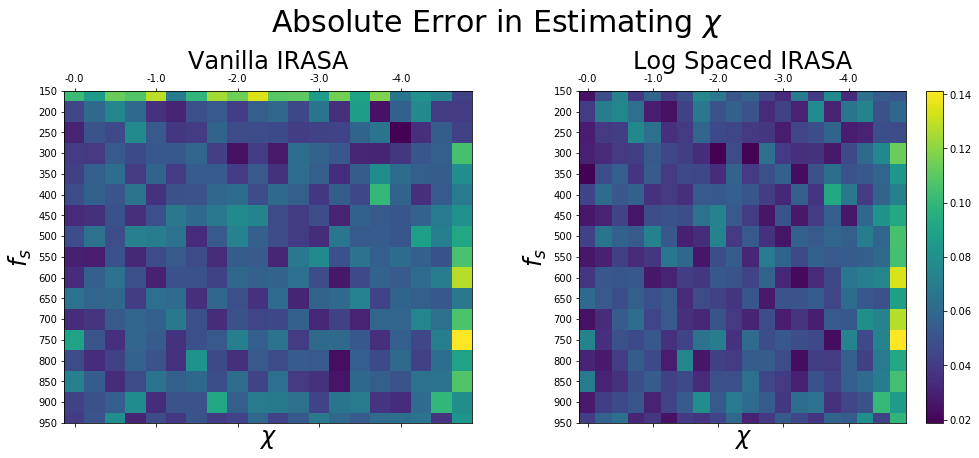

In [4]:
# Matrix plot
fig, axes = plt.subplots(1,2, figsize = (15,7))
cax = axes[0].matshow(df, aspect='auto')
cax2 = axes[1].matshow(df_log, aspect='auto')
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel(r"$f_s$", fontsize=24)
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel(r"$f_s$", fontsize=24)
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
        xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
        yticks=[idx for idx in range(0, FS_RANGE.shape[0])],
        yticklabels=[FS_RANGE[idx] for idx in range(0, FS_RANGE.shape[0])])
fig.suptitle(r"Absolute Error in Estimating $\chi$", fontsize=30)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
fig.tight_layout(pad=5.0)
fig.colorbar(cax)

## Aperiodic + 1 Sinusoid

Next, we see how the two versions of IRASA perform when we add one sinusoid to the aperiodic component. Instead of looking at the error as a function of $\chi$ and $f_s$, we will now look at it as a function of $\chi$ and the frequency of the oscillation.

In [5]:
# Create dataframes that will track the errors for vanilla IRASA and the log-spacing IRASA
df = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)
df_log = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)

tic = time()
for chi, freq, trial_idx in product(CHIS, FREQS, range(NUM_TRIALS)):
    # Grab the estimated exponent from IRASA. Add the absolute error to the
    # corresponding cell in the dataframe.
    irasa_exp = multiple_sines(N_SECONDS, FS, chi, [freq], F_RANGE)
    irasa_exp_logspace = multiple_sines(N_SECONDS, FS, chi, [freq], F_RANGE, log_space_irasa=True)
    df.loc[freq][chi] += np.abs(chi - irasa_exp)
    df_log.loc[freq][chi] += np.abs(chi - irasa_exp_logspace)

toc = time()
print(f"{toc-tic:.2f} seconds")
df /= NUM_TRIALS

419.13 seconds


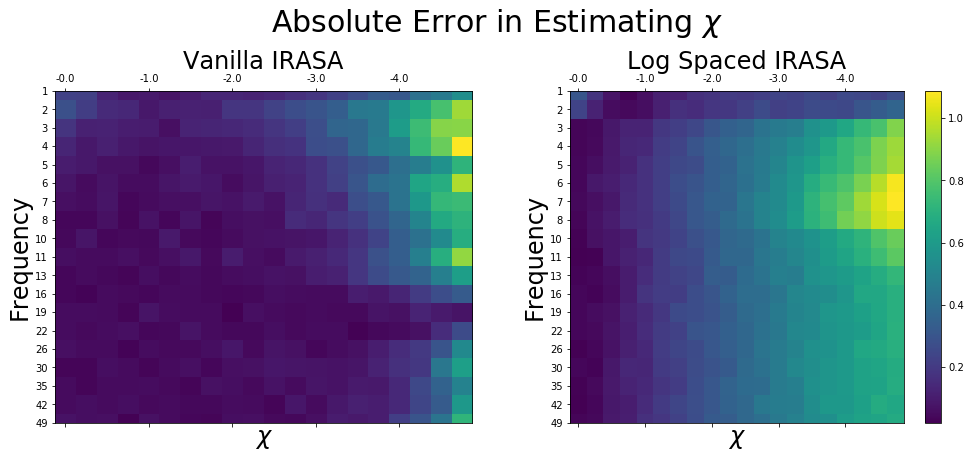

In [6]:
# Matrix plot
fig, axes = plt.subplots(1,2, figsize = (15,7))
cax = axes[0].matshow(df, aspect='auto')
cax2 = axes[1].matshow(df_log, aspect='auto')
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel("Frequency", fontsize=24)
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel("Frequency", fontsize=24)
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
        xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
        yticks=[idx for idx in range(0, len(FREQS))],
        yticklabels=[FREQS[idx] for idx in range(0, len(FREQS))])
fig.suptitle(r"Absolute Error in Estimating $\chi$", fontsize=30)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
fig.tight_layout(pad=5.0)
fig.colorbar(cax)

## Aperiodic + 4 Well-Spaced Sinusoids

IRASA does well with more than one simple oscillatory component provided the frequencies of the sinusoids are sufficiently far apart.

In [7]:
df = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)
df_log = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)
tic = time()
for chi, freq, trial_idx in product(CHIS, FREQS, range(NUM_TRIALS)):
    # Here, take 4 equispaced frequencies in log space between freq and the maximum frequency in F_RANGE.
    sine_freqs = log_space_freqs(np.arange(freq, F_RANGE[1]), 4)
    # Estimate chi
    irasa_exp = multiple_sines(N_SECONDS, FS, chi, sine_freqs, F_RANGE)
    irasa_exp_logspace = multiple_sines(N_SECONDS, FS, chi, sine_freqs, F_RANGE, log_space_irasa=True)
    df.loc[freq][chi] += np.abs(chi - irasa_exp)
    df_log.loc[freq][chi] += np.abs(chi - irasa_exp_logspace)
    
toc = time()
print(f"{toc-tic:.2f} seconds")
df /= NUM_TRIALS

483.50 seconds


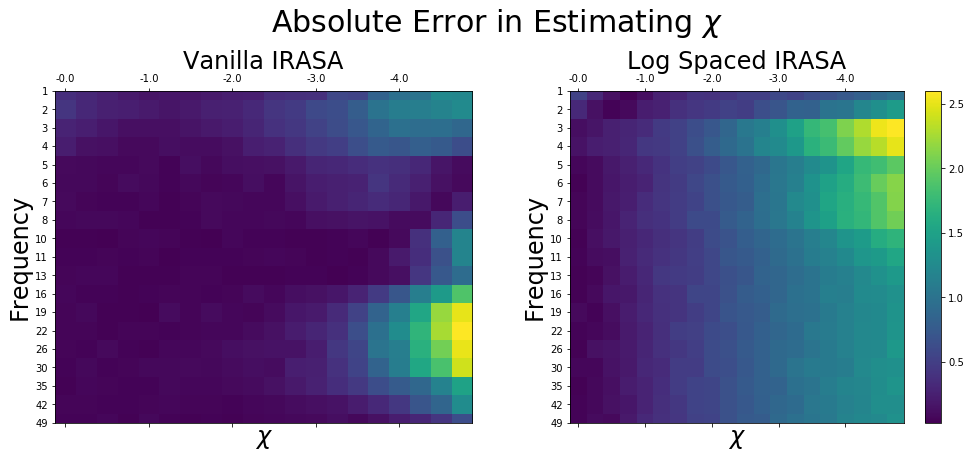

In [8]:
# Matrix plot
fig, axes = plt.subplots(1,2, figsize = (15,7))
cax = axes[0].matshow(df, aspect='auto')
cax2 = axes[1].matshow(df_log, aspect='auto')
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel("Frequency", fontsize=24)
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel("Frequency", fontsize=24)
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
        xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
        yticks=[idx for idx in range(0, len(FREQS))],
        yticklabels=[FREQS[idx] for idx in range(0, len(FREQS))])
fig.suptitle(r"Absolute Error in Estimating $\chi$", fontsize=30)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
fig.tight_layout(pad=5.0)
fig.colorbar(cax)

## Aperiodic + Cluster of Sinusoids

However, IRASA does have difficulties when there are multiple sinusoids whose frequencies are close to one another. Below, we superimpose an aperiodic component with a sum of sinusoids whose frequencies span a length of 0.5 in logarithmic spacing of frequencies.

In [8]:
df = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)
df_log = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)
bw = 0.5
tic = time()
for chi, freq, trial_idx in product(CHIS, FREQS, range(NUM_TRIALS)):
    # Sum sinusoids of frequencies whose bandwidth is bw in log space of frequencies.
    f_end = round(10**(bw + np.log10(freq)))
    sine_freqs = [freq for freq in np.arange(freq, f_end, 1./N_SECONDS)]
    irasa_exp = multiple_sines(N_SECONDS, FS, chi, sine_freqs, F_RANGE)
    irasa_exp_logspace = multiple_sines(N_SECONDS, FS, chi, sine_freqs, F_RANGE, log_space_irasa=True)
    df.loc[freq][chi] += np.abs(chi - irasa_exp)
    df_log.loc[freq][chi] += np.abs(chi - irasa_exp_logspace)
toc = time()
print(f"{toc-tic:.2f} seconds")
df /= NUM_TRIALS

1205.41 seconds


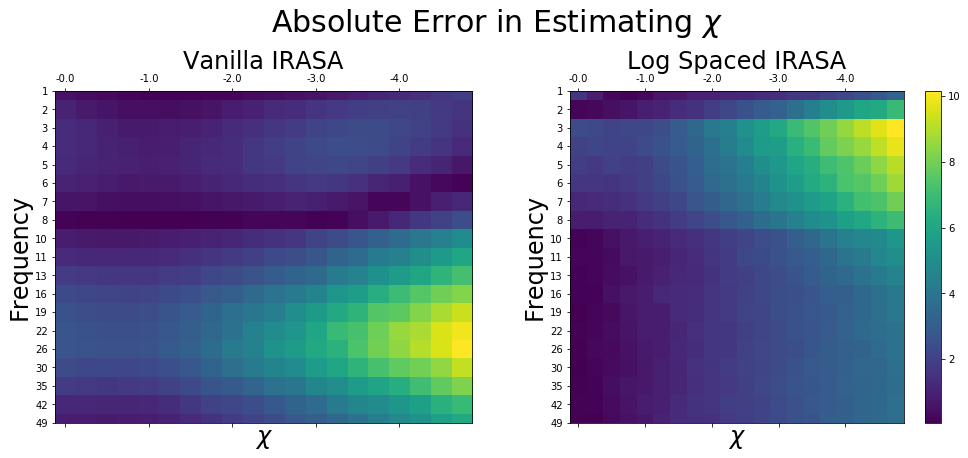

In [9]:
# Matrix plot
fig, axes = plt.subplots(1,2, figsize = (15,7))
cax = axes[0].matshow(df, aspect='auto')
cax2 = axes[1].matshow(df_log, aspect='auto')
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel("Frequency", fontsize=24)
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel("Frequency", fontsize=24)
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
        xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
        yticks=[idx for idx in range(0, len(FREQS))],
        yticklabels=[FREQS[idx] for idx in range(0, len(FREQS))])
fig.suptitle(r"Absolute Error in Estimating $\chi$", fontsize=30)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
fig.tight_layout(pad=5.0)
fig.colorbar(cax)

## Aperiodic with Central Frequency

Now we'll test how IRASA performs on signals with an oscillatory and aperiodic component as in the context of FOOOF where there is a central frequency with a pre-defined bandwidth and relative height above the aperiodic component. Here, we'll look at the absolute error as a function of chi, the central_frequency, and the bandwidth. This experiment takes a very long time to run because there are so many parameters to run experiments over. To look at the results of one instance of this experiment, you can run the cell that loads the dataframe from a csv file.

In [13]:
# Set constants for this particular experiment
HEIGHTS = np.arange(0.1, 2, 0.1)
BANDWIDTHS = np.arange(1, 10, 0.5)
parameter_grid = list(product(FREQS, HEIGHTS, BANDWIDTHS))
index = pd.MultiIndex.from_tuples(parameter_grid, names=['central_freq', 'relative_height', 'bandwidth'])
num_rows = HEIGHTS.shape[0]*BANDWIDTHS.shape[0]*FREQS.shape[0]
df = pd.DataFrame(data=np.zeros((num_rows, CHIS.shape[0])), index=index, columns=CHIS)

In [29]:
# This takes 6 days to run because the grid is huge. Each experiment takes about 6.33 seconds to run.
tic = time()
for chi, central_freq, ht, bw, trial_idx in product(CHIS, FREQS, HEIGHTS, BANDWIDTHS, range(NUM_TRIALS)):
    irasa_exp = central_frequency(N_SECONDS, FS, chi, central_freq, bw, ht, F_RANGE)
    df.loc[central_freq, ht, bw][chi] += np.abs(chi - irasa_exp)
toc = time()
print(f"{toc-tic:.2f} seconds")
df /= NUM_TRIALS

494127.86 seconds


In [197]:
df = pd.read_csv('full_central_freq_IRASA_experiment.csv')
# Reindex dataframe
df = df.set_index(keys=['central_freq', 'relative_height', 'bandwidth'])

In [218]:
df[df.index.get_level_values('relative_height').isin(rel_heights)][[f"{chi}" for chi in chis]].min().min()

0.02605902401854765

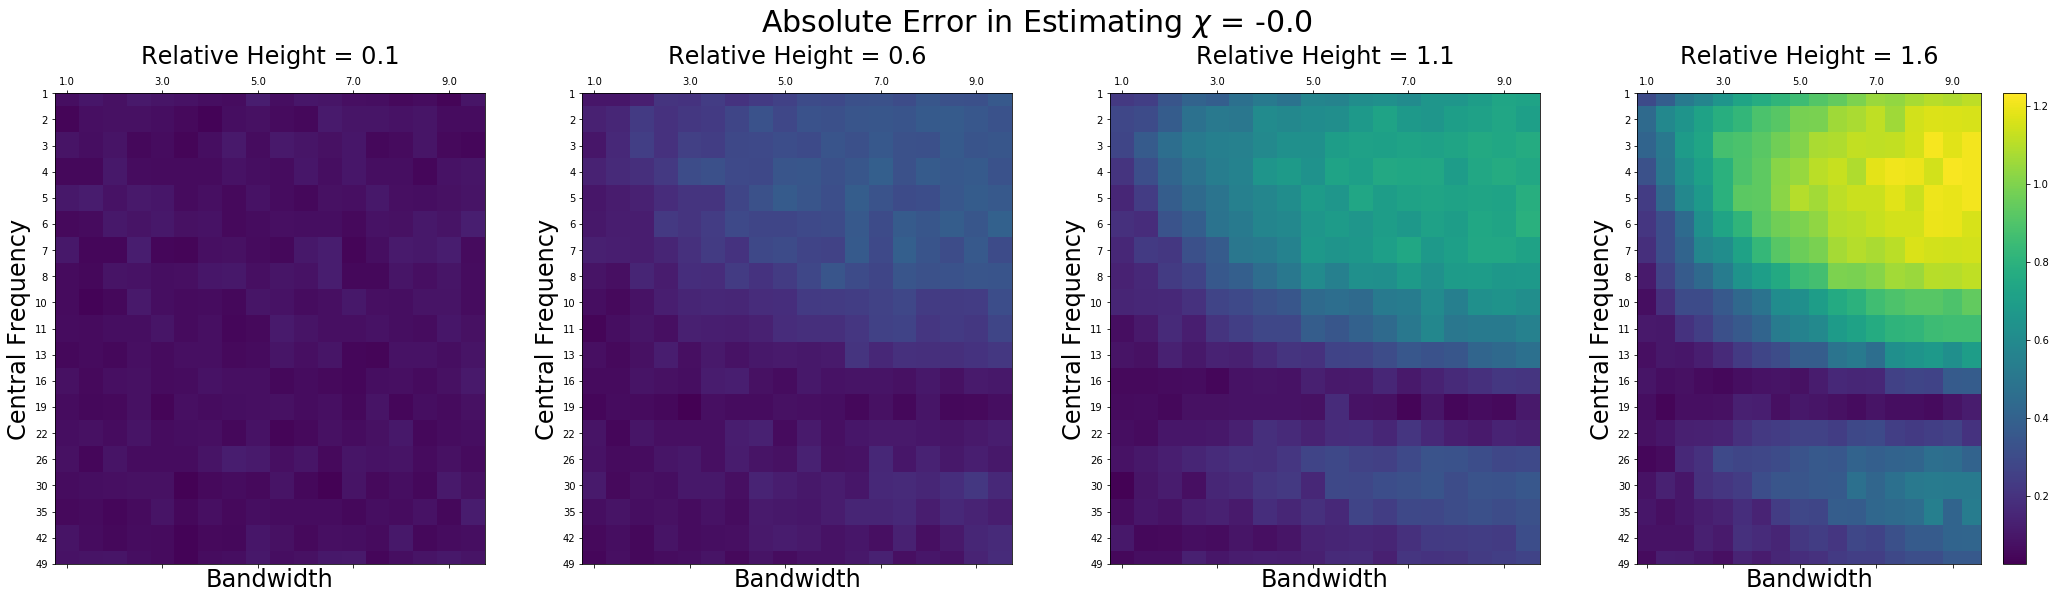

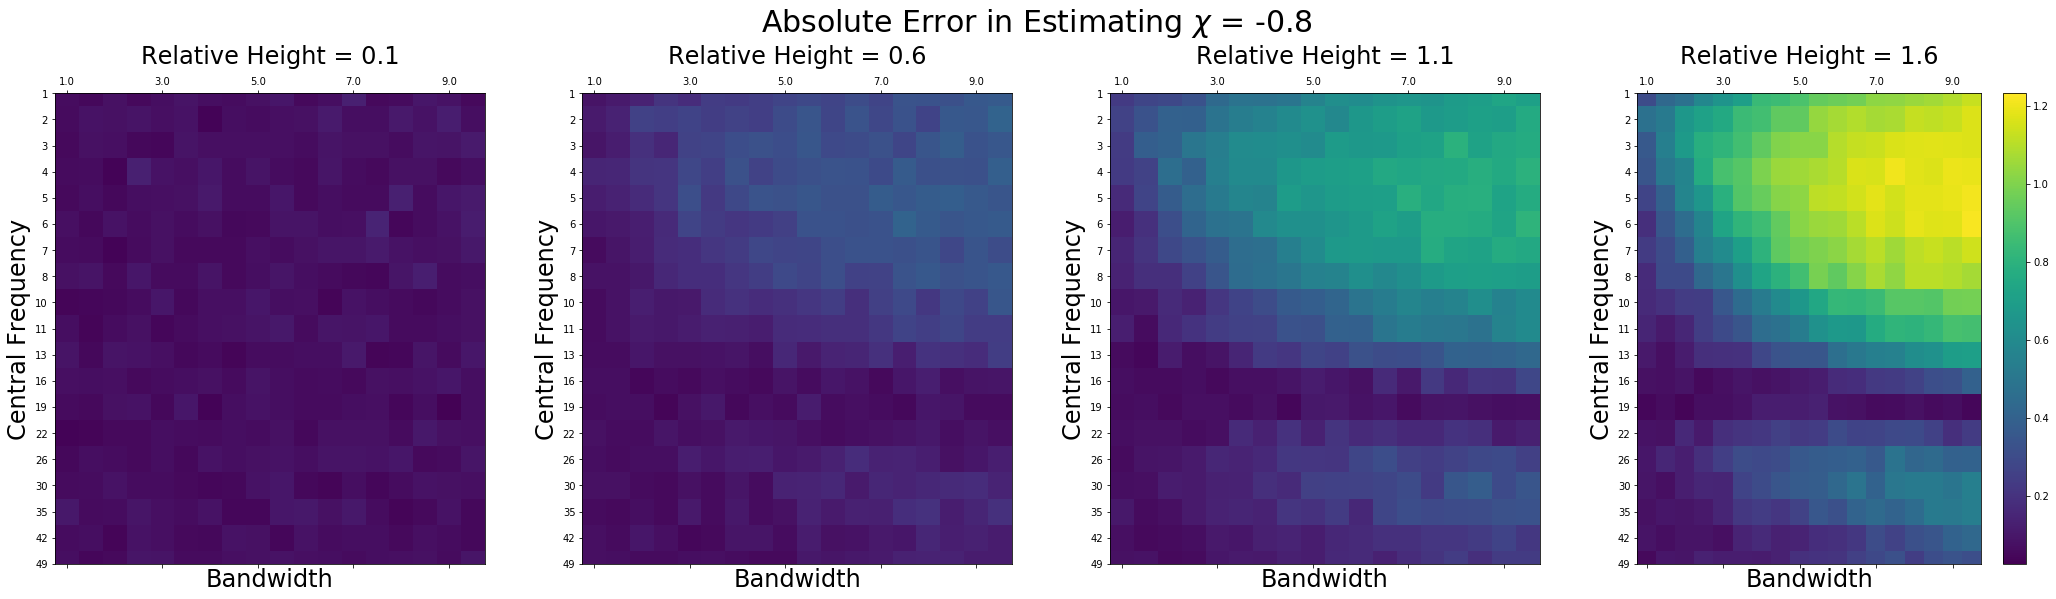

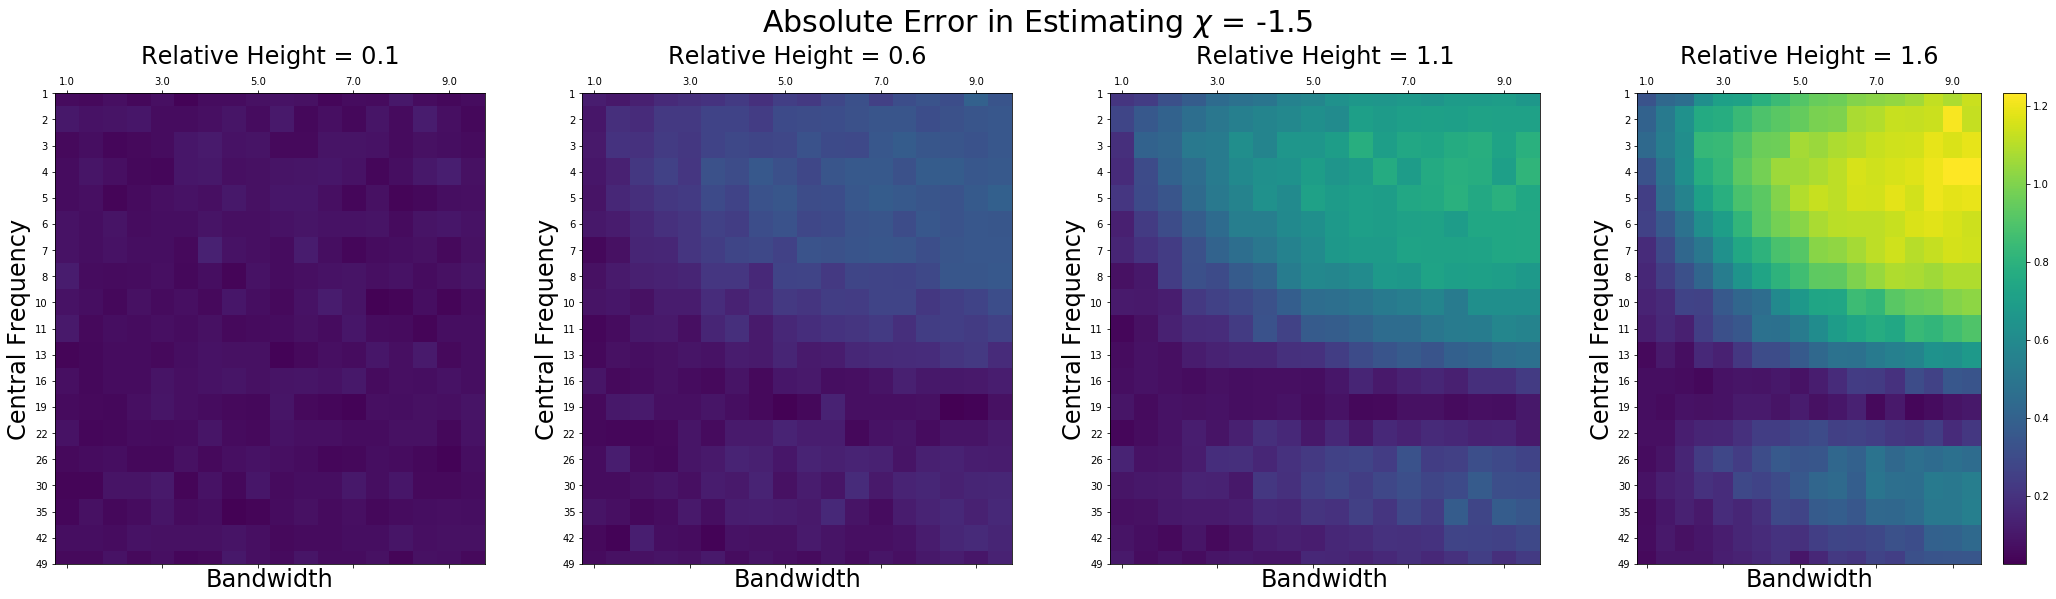

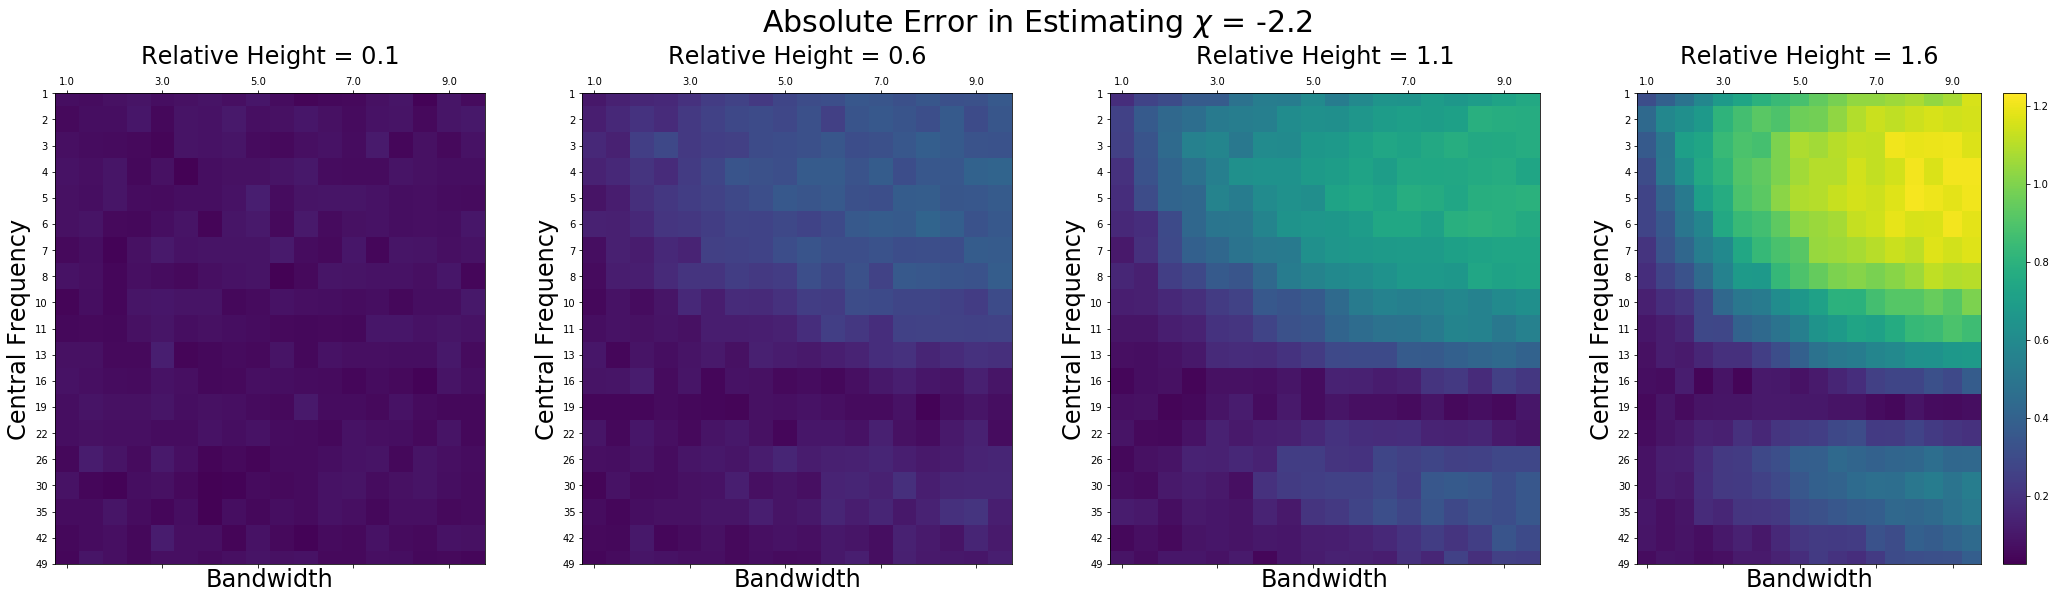

In [219]:
rel_heights = HEIGHTS[0:-1:5]
chis = CHIS[0:-1:3]

# Grab the dynamic range of the absolute errors for the experiments run with the relative heights and chis
# that we're looking at
vmin = df[df.index.get_level_values('relative_height').isin(rel_heights)][[f"{chi}" for chi in chis]].min().min()
vmax = df[df.index.get_level_values('relative_height').isin(rel_heights)][[f"{chi}" for chi in chis]].max().max()

for chi in chis:
    fig, axes = plt.subplots(1,4, figsize = (30,9))
    for idx, ax in enumerate(axes.ravel()):

        df_freq_vs_bw = df.iloc[df.index.get_level_values('relative_height') == rel_heights[idx]][f"{chi}"]
        df_freq_vs_bw = df_freq_vs_bw.droplevel('relative_height').unstack(level=-1)
        
        cax = ax.matshow(df_freq_vs_bw, aspect='auto', vmin=vmin, vmax=vmax)
        ax.set_xlabel("Bandwidth", fontsize=24)
        ax.set_ylabel("Central Frequency", fontsize=24)
        plt.setp(ax, xticks=[idx for idx in range(0, BANDWIDTHS.shape[0], 4)],
                xticklabels=[BANDWIDTHS[idx] for idx in range(0, BANDWIDTHS.shape[0], 4)],
                yticks=[idx for idx in range(0, len(FREQS))],
                yticklabels=[FREQS[idx] for idx in range(0, len(FREQS))])
        ax.set_title(rf"Relative Height = {rel_heights[idx]:.1f}", fontsize=24)
    fig.colorbar(cax)
    fig.suptitle(rf"Absolute Error in Estimating $\chi$ = {chi:0.1f}", fontsize=30)
    fig.tight_layout(pad=5.0)
    